# СЕПТА
### Юго-Восточное траспортное управление штата Пенсильвания. Исследовательский анализ

СЕПТА (SEPTA - Southeastern Pennsylvania Transportation Authority) это региональная транспортная система, которая состоит из 13 линий метрополитена и более чем 150-ти станций пересадок местного и регионального значения в штатах Филадельфия, Пенсильвания, их пригородов и их городов-саттелитов.

СЕПТА использует систему OTP (On-Time Performance, соблюдение транспортом графика движения) для оценки надежности и безопасности работы транспортной сети. Система оценивает параметры движения поездов по их идентификационному номеру от станции к станции на всех линиях. СЕПТА установила цель выйти в ежегодный показатель 91% OTP по соблюдению графика движения для всех поездов. В данном анализе мы рассмотрим основные показатели работы этой транспортной системы.

<img src='septa.png'>

### Загрузка данных
Загрузим данные из csv файла в блок данных pandas.

In [1]:
import pandas as pd

df = pd.read_csv('otp.csv')

Сконвертируем графы "Date" и "Timestamp" в формат datetime pandas. 

In [2]:
df.Date = pd.to_datetime(df.Date, errors='coerce') 
df.Timestamp = pd.to_datetime(df.Timestamp, errors='coerce')

В какой временной период были собраны данные? 

In [3]:
print(df.Date.min())
print(df.Date.max())

2016-03-23 00:00:00
2016-06-10 00:00:00


Какое количество станций входит в транспортную сеть?

In [4]:
df.Station.nunique()

155

Cконвертируем графу "Status" из объектного типа данных в числовой, заменив значение "On Time" на время задержки, равное 0 минут ожидания.

In [5]:
df.Status = df.Status.str.replace('On Time','0').str.replace('min','')
df.Status = pd.to_numeric(df.Status)

Каков общий диапазон задержек?

In [6]:
print(df.Status.min())
print(df.Status.max())

0
999


Значение "999" означает что поезд был задержан и не прибыл на станцию назначения. Мы исключим эти данные из нашего анализа. Каков новый диапазон задержек?  

In [7]:
df = df[df.Status != 999]

print(df.Status.min())
print(df.Status.max())

0
119


### Задержка поездов по времени в северном и южном направлениях 
Существует ли разница задержки поездов по времени между северным и южным направлениями?

In [8]:
print(df.groupby('Direction').mean())

             Status
Direction          
N          2.207776
S          2.922220


Исходя их полученных значений можно увидеть что поезда южного направления (около 3 минут) идут немного быстрее чем поезда северного направления (около 2 минут и 20 секунд). Для того чтобы понять, является ли это значение статистически значимым, мы проведем тест Стьюдента, предполагая что поезда северного и южного направления относятся к популяции с одинаковой вариативностью.

In [9]:
from scipy import stats

rvs1 = df.Status[df.Direction == 'N']
rvs2 = df.Status[df.Direction == 'S']
t_stat, p_val = stats.ttest_ind(rvs1, rvs2, equal_var=True)

print('t-statistic: {0}'.format(round(t_stat, 2)))
print('p-value: {0}'.format(round(p_val, 2)))

t-statistic: -75.53
p-value: 0.0


P-значение теста черезвычайно мало, что указывает на то, что мы можем отвергнуть основную гипотезу и принять конкурирующую гипотезу что между средними математическими ожиданиями задержек движения поездов северного и южного направления действительно существует статистическая разница.

### Задержка поездов по дням недели
Следующим шагом мы рассмотрим задержки поездов по дням недели. Для этого мы создадим дополнительную графу "День недели" ("Weekday") и сконверируем названия дней из числовых в объектные значения.

In [10]:
df['Weekday'] = df.Timestamp.dt.dayofweek

days = {0:'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df.Weekday = df.Weekday.apply(lambda x: days[x])

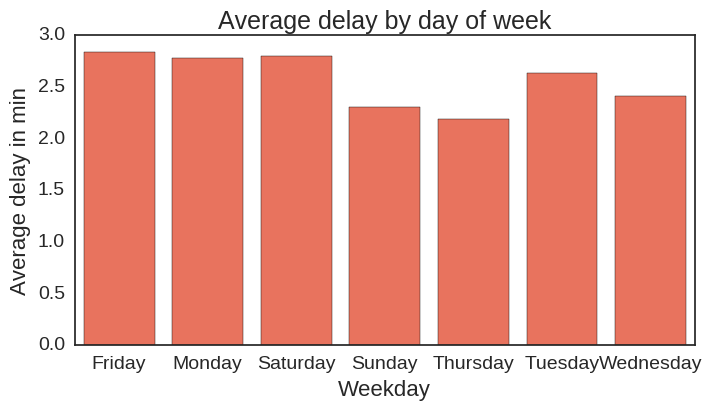

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

fig = plt.figure(figsize=(8,4))
plt.tick_params(labelsize=14)

data = df.groupby('Weekday').mean()
sns.barplot(x=data.index, y=data.Status, color='tomato')

plt.xlabel('Weekday', fontsize=16)
plt.ylabel('Average delay in min', fontsize=16)
plt.title('Average delay by day of week', fontsize=18)
plt.show()

Где "Average delay by day of week" это средняя задержка по дням недели. Из графа видно что самые загруженные дни недели это пятница, понедельник и суббота, что коррелирует с логикой распределения пассажирских потоков по дням недели.

### Задержка поездов в течении дня
Следующим шагом мы рассмотрим задержку поездов по времени в течении дня.

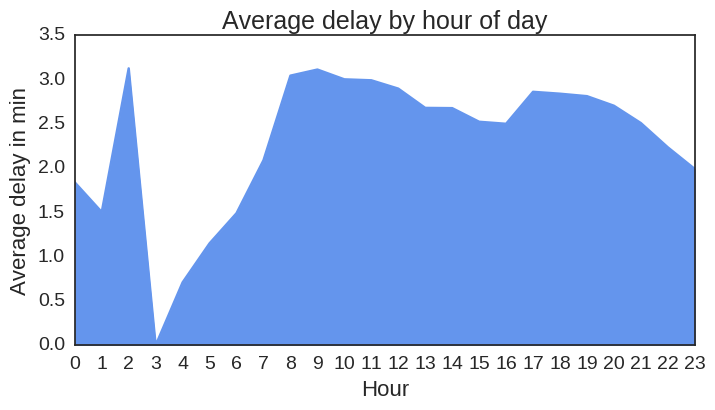

In [12]:
from pylab import fill_between

data = df.groupby(pd.DatetimeIndex(df['Timestamp']).hour).mean()

fig, ax = plt.subplots(figsize=(8,4))
ax.set_xticks(range(len(data.index)))
plt.tick_params(labelsize=14)

plt.plot(data.index, data.Status, color='cornflowerblue')
fill_between(data.index, data.Status, color='cornflowerblue', alpha=1)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Average delay in min', fontsize=16)
plt.title('Average delay by hour of day', fontsize=18)
plt.show()

Где "Average delay by hour of day" это средняя задержка по часам дня. На данном графике видно что два наибольших значения по времени задержки поездов приходятся на 9 часов утра и 17 часов вечера, что соответствует утренним и вечерним часам пик. Пиковое значение в 2 часа ночи не укладывается в эту логику и должно быть изучено отдельно.

### Задержка поездов по станции отправления
Следующим шагом мы рассмотрим время задержки по станции отправления. В связи с тем, что количество станций очень велико, мы рассмотрим только основные, крупные пересадочные терминалы, расположенные в конце каждой линии метрополитена.

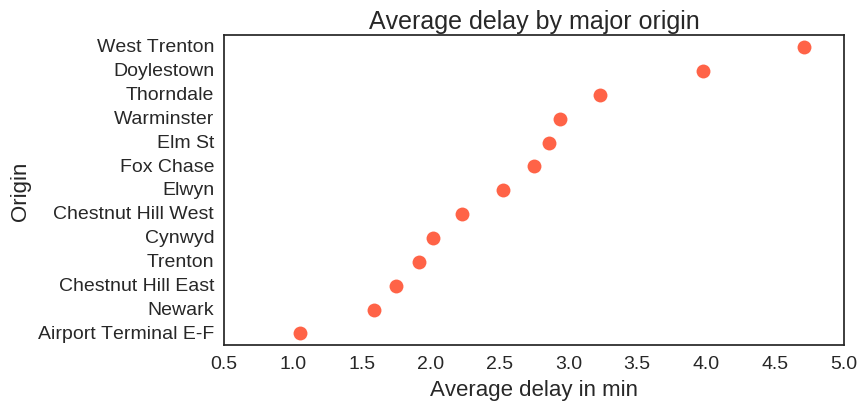

In [13]:
terminals = ['Doylestown', 'Warminster', 'West Trenton', 'Trenton', 'Fox Chase',
             'Chestnut Hill East', 'Chestnut Hill West', 'Elm St', 'Thorndale',
             'Elwyn', 'Newark', 'Airport Terminal E-F', 'Cynwyd']

data = df.groupby(df.Origin[df.Origin.isin(terminals)]).mean().sort_values(
    by='Status', ascending=False)

fig = plt.figure(figsize=(8,4))
plt.tick_params(labelsize=14)

sns.stripplot(x=data.Status, y=data.index,color='tomato', size=10)
plt.xlabel('Average delay in min', fontsize=16)
plt.ylabel('Origin', fontsize=16)
plt.title('Average delay by major origin', fontsize=18)
plt.show()

Где "Average delay by major origin" это средняя задержка по станции отправления. Из графика видно что поезда прибывающие из West Trenton и Doylestown имеют самые высокие показатели 
задержки. Поезда идущие из Newark, Airport, и Chestnut Hill East имеют средние показатели задержки. 

### Задержка поездов по станции прибытия
Теперь мы рассмотрим время задержки по станции прибытия.  

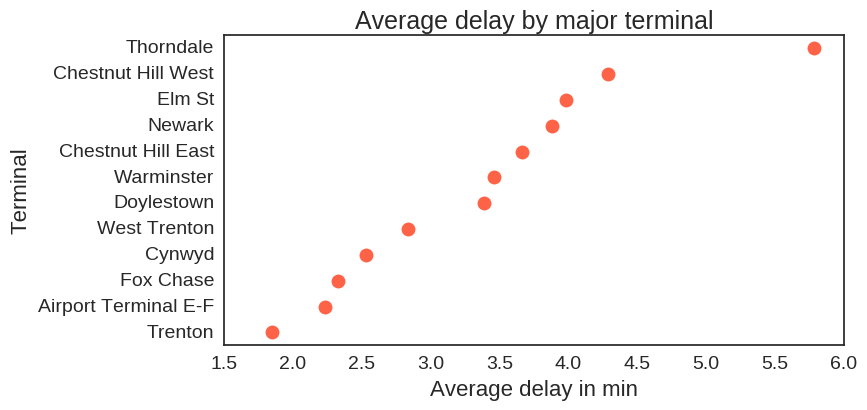

In [14]:
data = df.groupby(df.Station[df.Station.isin(terminals)]).mean().sort_values(
    by='Status', ascending=False)

fig = plt.figure(figsize=(8,4))
plt.tick_params(labelsize=14)

sns.stripplot(x=data.Status, y=data.index,color='tomato', size=10)
plt.xlabel('Average delay in min', fontsize=16)
plt.ylabel('Terminal', fontsize=16)
plt.title('Average delay by major terminal', fontsize=18)
plt.show()

Где "Average delay by major terminal" это средняя задержка по станции прибытия. Мы видим, что поезда прибывающие на станцию Thorndale опаздывают гораздо сильнее чем поезда идущие в другие крупные терминалы. Поезда прибывающие на станции Trenton и Airport имеют наименьшее время опоздания.